In [2]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../..')))

In [3]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display

from lpn_mrs.datasets import MRSDataset
from lpn_mrs.networks import LPN, LPN_cond, LPN_cond_encode_nn

In [4]:
from sklearn.decomposition import PCA
from scipy.spatial import KDTree

In [5]:
# Visualize true distribution using PCA
true_dataset = MRSDataset(root='../data', split='train', data_type='low_lipid')
all_samples = np.array([true_dataset[i] for i in range(len(true_dataset))])

mean = np.mean(all_samples, axis=0)
centered_samples = all_samples - mean

pca = PCA(n_components=2)
true_proj = pca.fit_transform(centered_samples) 
pc_vector = pca.components_

print(true_proj.shape)
print(pc_vector.shape)

(500, 2)
(2, 512)


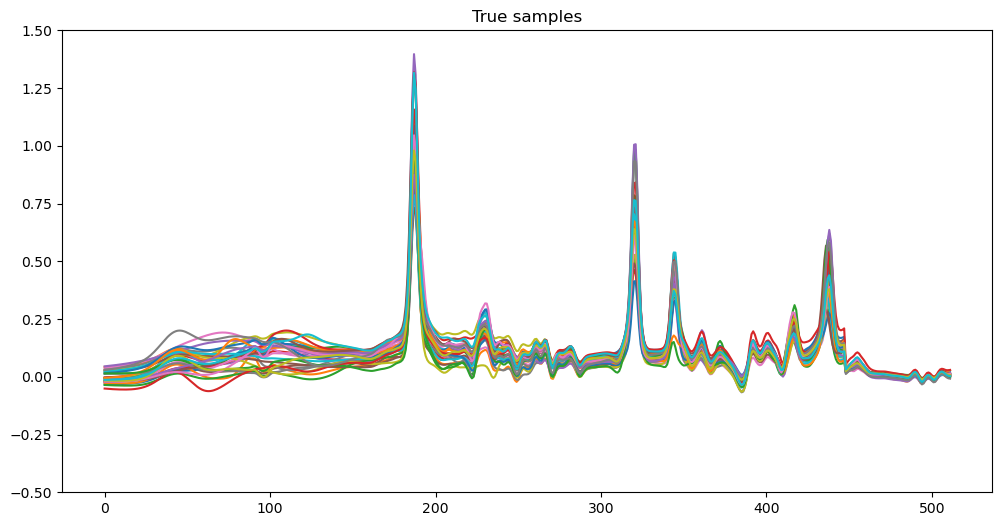

In [6]:
plt.figure(figsize=(12,6))
for i in range(30):
    plt.plot(all_samples[i,:])
plt.title('True samples')
plt.ylim(-0.5, 1.5)
plt.show()

In [7]:
noise_init = 0.1
noise_final = 0.001
num_stage = 5
noise_schedule = np.linspace(noise_init, noise_final, num_stage)
noise_schedule

array([0.1    , 0.07525, 0.0505 , 0.02575, 0.001  ])

In [8]:
x0 = np.mean(np.array([true_dataset[i] for i in range(len(true_dataset))]), axis=0)
n_samples = 30

# Three levels of sampling methods:

1. Langevin sampling on empirical distribution: 

$p_x \sim \frac{1}{n} \sum_{i=1}^n \delta_i(X_i)$ and 

$\tt{prox}_{-\sigma^2 \log p_x} = \tt{Proj}_X$

In [22]:
tree = KDTree(all_samples)

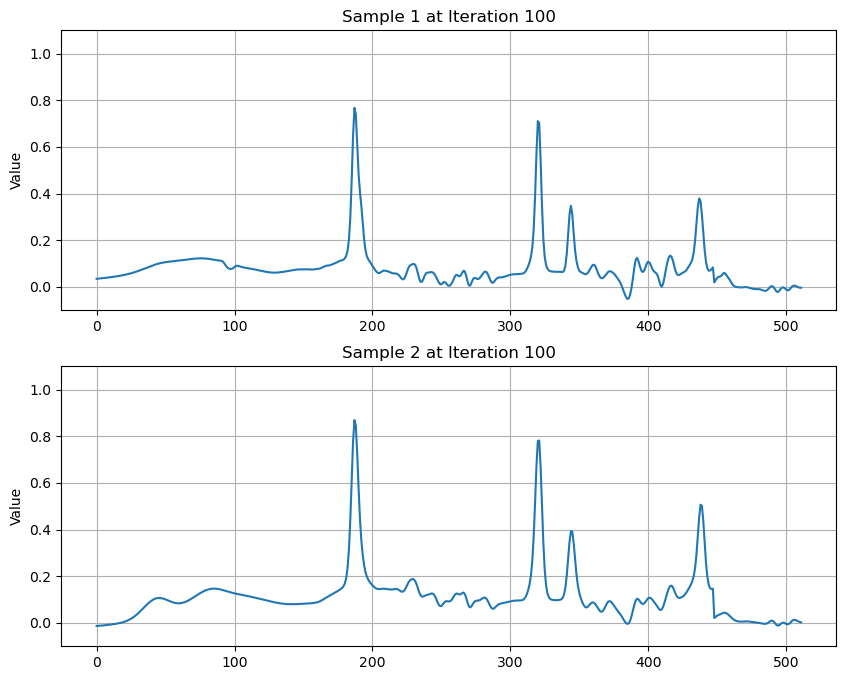

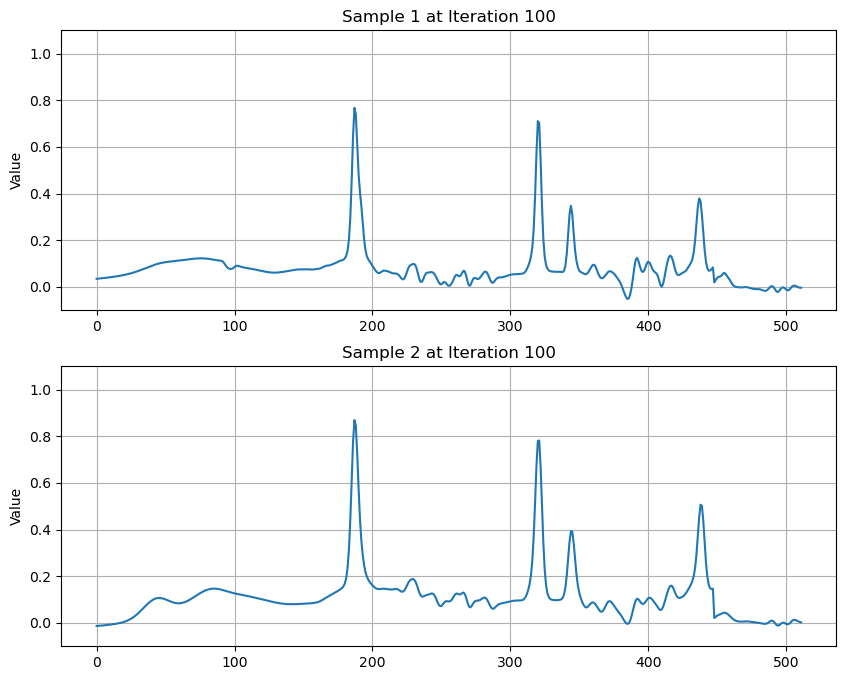

In [23]:
x_emp = np.tile(x0, (n_samples, 1))
projections_emp = []
max_iter = 100

plt.ion()  # Enable interactive mode for real-time plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for it in range(max_iter):
    noise = noise_schedule[it // (max_iter // num_stage)]
    x_noisy = x_emp + np.random.normal(0, 1, size=x_emp.shape) * np.sqrt(2) * noise

    dist, indices = tree.query(x_noisy)
    x_emp = all_samples[indices]

    proj = np.dot(x_emp - mean, pc_vector.T)
    projections_emp.append(proj)

    clear_output(wait=True)

    for i in range(2):
        axs[i].cla()  # Clear axes
        axs[i].plot(x_emp[i]) 
        axs[i].set_title(f'Sample {i + 1} at Iteration {it + 1}') 
        axs[i].set_ylabel('Value')
        axs[i].set_ylim(-0.1,1.1)
        axs[i].grid(True)

    display(fig)

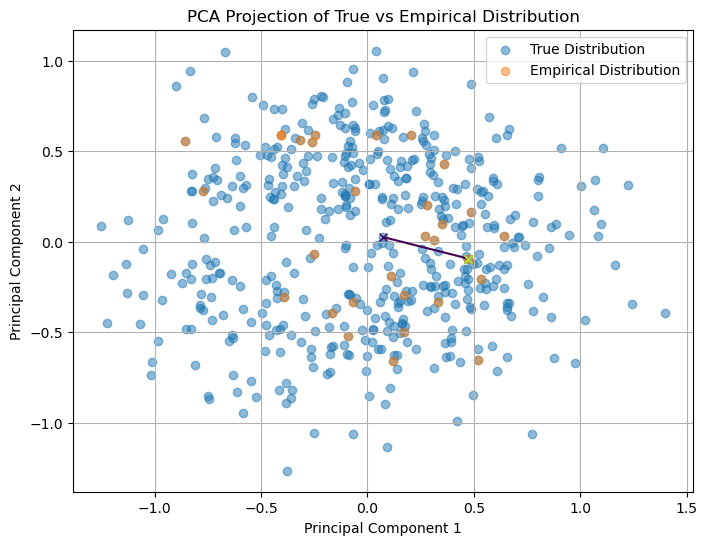

In [24]:
proj_emp = np.array(projections_emp)
colors = np.linspace(0, 1, max_iter)
step_size = 10

plt.figure(figsize=(8, 6))
plt.scatter(true_proj[:, 0], true_proj[:, 1], alpha=0.5, label='True Distribution')
plt.scatter(proj_emp[-1][:, 0], proj_emp[-1][:, 1], alpha=0.5, label='Empirical Distribution')

for i in range(0, max_iter, step_size):
    plt.plot(proj_emp[i:(i + step_size + 1):step_size,10,0], proj_emp[i:(i + step_size + 1):step_size, 10, 1], marker='x', color=plt.cm.viridis(colors[int(i)]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of True vs Empirical Distribution')
plt.legend()
plt.grid(True)
plt.show()

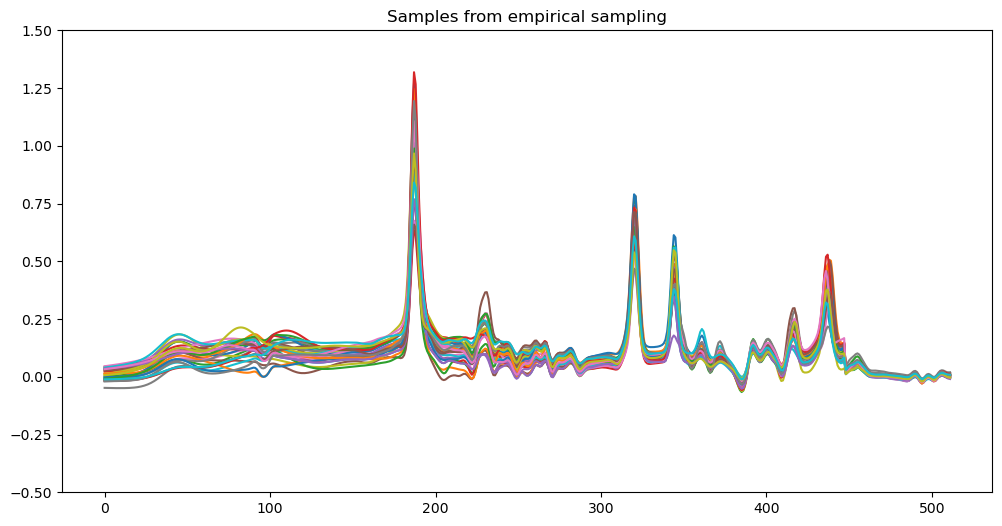

In [25]:
plt.figure(figsize=(12,6))
for i in range(len(x_emp)):
    plt.plot(x_emp[i, :])
plt.title('Samples from empirical sampling')
plt.ylim(-0.5, 1.5)
plt.show()

2. Langevin sampling for GMM

For one-center GMM model: $p_x \sim N(\mu, \Sigma)$, $\tt{prox}_{-\sigma^2 \log p_x}(x) = (I + \sigma^2 \Sigma^{-1})^{-1} (x + \sigma^2 \Sigma^{-1} \mu)$

In [26]:
# Fit GMM model
from sklearn.mixture import GaussianMixture

best_gmm = GaussianMixture(n_components=1)
best_gmm.fit(all_samples)
mu = best_gmm.means_[0]
Sigma = best_gmm.covariances_[0]
Sigma_inv = np.linalg.inv(Sigma)

inv_list = []
for sigma in noise_schedule:
    inv_list.append(np.linalg.inv(np.eye(Sigma.shape[0]) + sigma**2 * Sigma_inv))

inv_list = np.array(inv_list)
print(inv_list.shape)

(5, 512, 512)


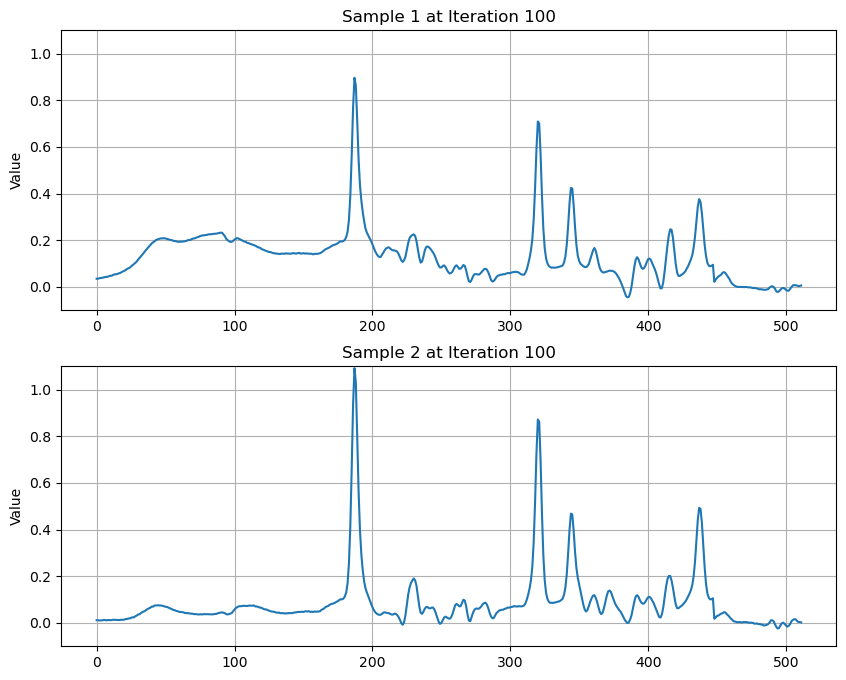

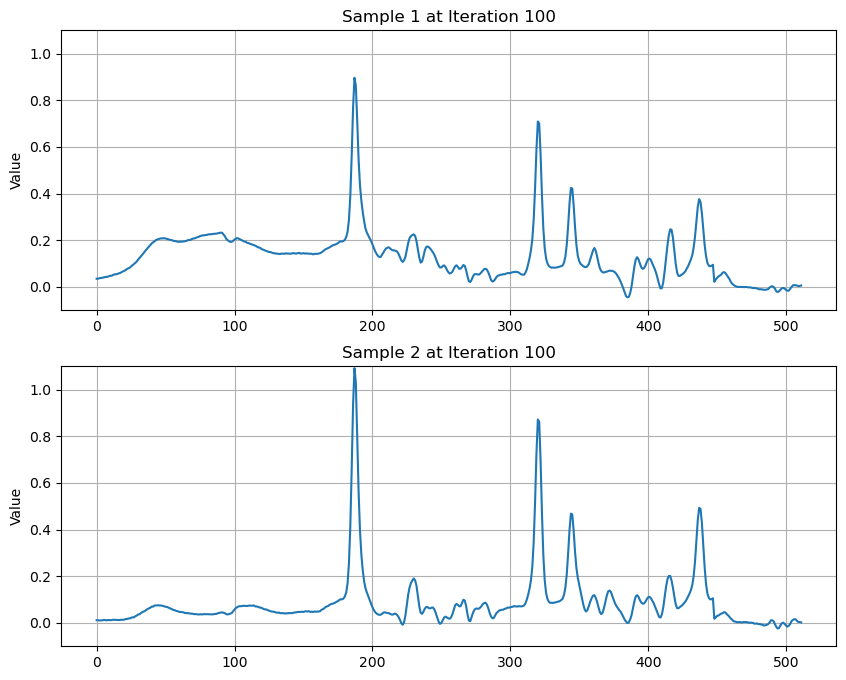

In [27]:
x_gmm = np.tile(x0, (n_samples, 1))
projections_gmm = []
max_iter = 100

plt.ion()  # Enable interactive mode for real-time plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for it in range(max_iter):
    stage_id = it // (max_iter // num_stage)
    sigma = noise_schedule[stage_id]
    x_noisy = x_gmm + np.random.normal(0, 1, size=x_gmm.shape) * np.sqrt(2) * sigma

    for i in range(len(x_gmm)):
        x_gmm[i] = inv_list[stage_id] @ (x_noisy[i] + sigma ** 2 * Sigma_inv @ mu)

    proj = np.dot(x_gmm - mean, pc_vector.T)
    projections_gmm.append(proj)

    clear_output(wait=True)

    for i in range(2):
        axs[i].cla()  # Clear axes
        axs[i].plot(x_gmm[i]) 
        axs[i].set_title(f'Sample {i + 1} at Iteration {it + 1}') 
        axs[i].set_ylabel('Value')
        axs[i].set_ylim(-0.1,1.1)
        axs[i].grid(True)

    display(fig)

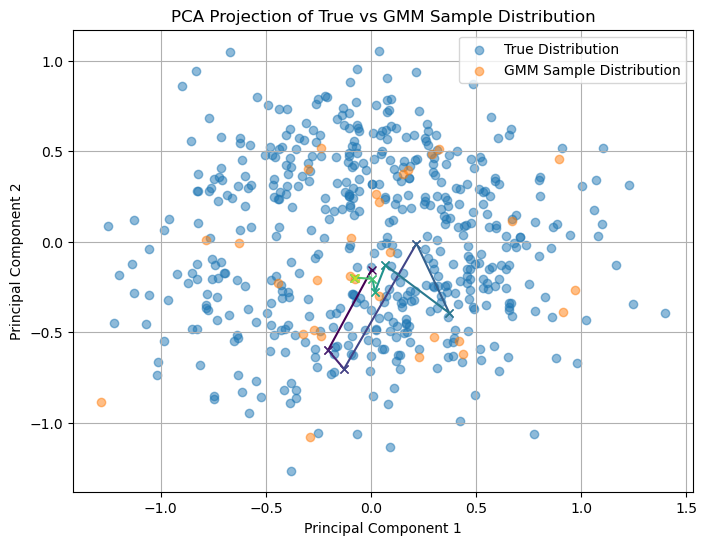

In [28]:
proj_gmm = np.array(projections_gmm)
colors = np.linspace(0, 1, max_iter)
step_size = 10

plt.figure(figsize=(8, 6))
plt.scatter(true_proj[:, 0], true_proj[:, 1], alpha=0.5, label='True Distribution')
plt.scatter(proj_gmm[-1][:, 0], proj_gmm[-1][:, 1], alpha=0.5, label='GMM Sample Distribution')

for i in range(0, max_iter, step_size):
    plt.plot(proj_gmm[i:(i + step_size + 1):step_size,10,0], proj_gmm[i:(i + step_size + 1):step_size, 10, 1], marker='x', color=plt.cm.viridis(colors[int(i)]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of True vs GMM Sample Distribution')
plt.legend()
plt.grid(True)
plt.show()

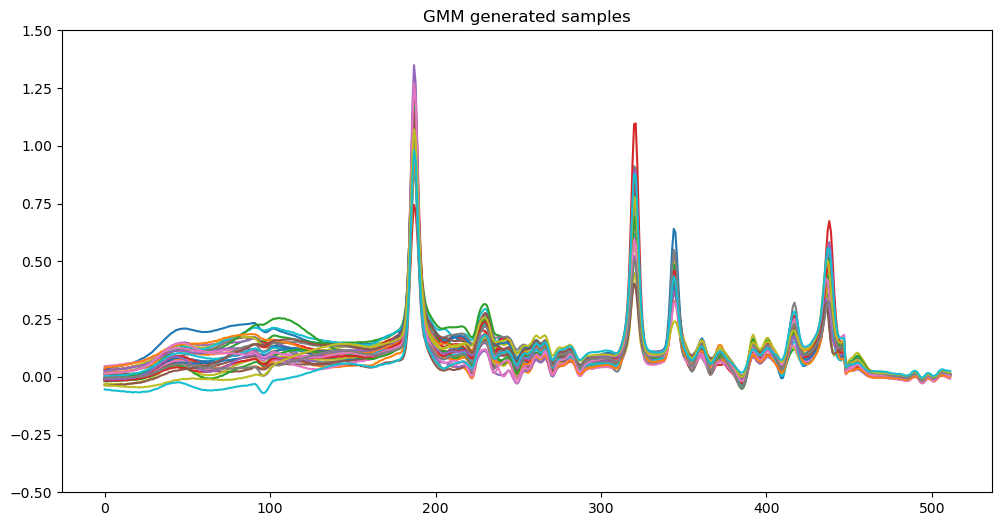

In [29]:
plt.figure(figsize=(12,6))
for i in range(len(x_gmm)):
    plt.plot(x_gmm[i,:])
plt.title('GMM generated samples')
plt.ylim(-0.5, 1.5)
plt.show()

3. Langevin Sampling for LPN trained encoding

In [30]:
kernel = 3
hidden = 30
sigma_min = 0.001
sigma_max = 0.1
max_iter = 100
model_name = 'LPN_cond_encode_nn'

model = LPN_cond_encode_nn(in_dim = 1, hidden_c=1, hidden=hidden, kernel=kernel, beta=10, alpha=1e-6)
model.load_state_dict(torch.load(f"../weights/{model_name.lower()}_mrs_h_{hidden}_k_{kernel}_n_({sigma_min}_{sigma_max})/LPN_best.pt"))

<All keys matched successfully>

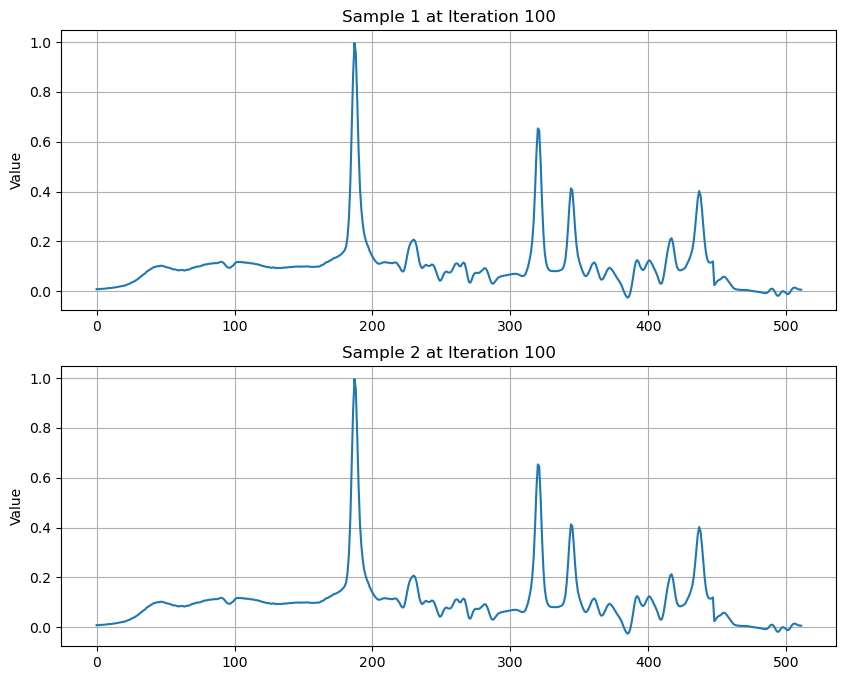

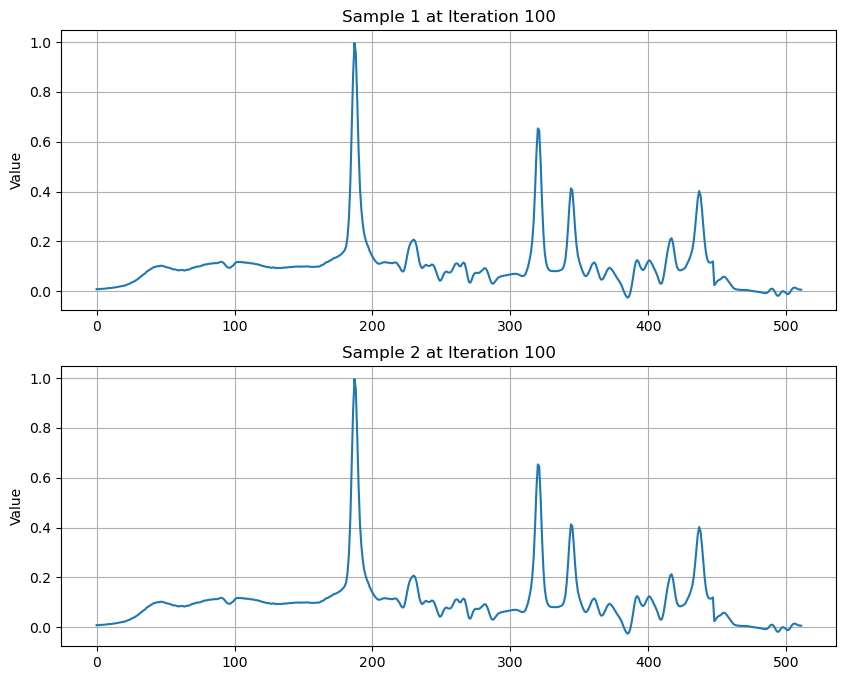

In [31]:
x_lpn_encode = np.tile(x0, (n_samples, 1))
x_lpn_encode = torch.tensor(x_lpn_encode).unsqueeze(1)

projections_lpn_encode = []

plt.ion()  # Enable interactive mode for real-time plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for it in range(max_iter):
    current_sample = x_lpn_encode.squeeze(1).detach().cpu().numpy()
    proj = (current_sample - mean) @ pc_vector.T
    projections_lpn_encode.append(proj)
    
    clear_output(wait=True)

    for i in range(2):
        axs[i].cla()  # Clear axes
        axs[i].plot(current_sample[i]) 
        axs[i].set_title(f'Sample {i + 1} at Iteration {it + 1}') 
        axs[i].set_ylabel('Value')
        axs[i].grid(True)

    display(fig)

    stage_id = it // (max_iter // num_stage)
    sigma = noise_schedule[stage_id]

    noise_levels = torch.full((n_samples,1), sigma)
    x_lpn_encode = model(x_lpn_encode + torch.randn_like(x_lpn_encode) * sigma * np.sqrt(2), noise_levels)

# After the loop, keep the plot open
plt.ioff()  # Disable interactive mode
plt.show()

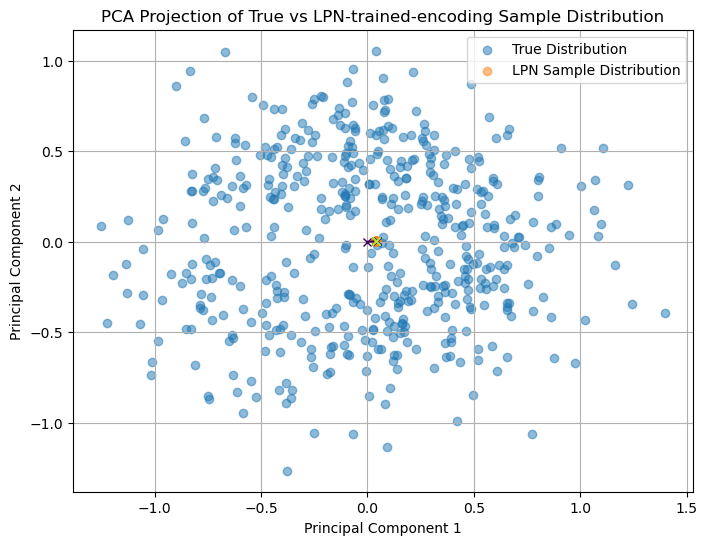

In [32]:
proj_lpn_encode = np.array(projections_lpn_encode)
colors = np.linspace(0, 1, max_iter)
step_size = 10

plt.figure(figsize=(8, 6))
plt.scatter(true_proj[:, 0], true_proj[:, 1], alpha=0.5, label='True Distribution')
plt.scatter(proj_lpn_encode[-1][:, 0], proj_lpn_encode[-1][:, 1], alpha=0.5, label='LPN Sample Distribution')

for i in range(0, max_iter, step_size):
    plt.plot(proj_lpn_encode[i:(i + step_size + 1):step_size,10,0], proj_lpn_encode[i:(i + step_size + 1):step_size, 10, 1], marker='x', color=plt.cm.viridis(colors[int(i)]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of True vs LPN-trained-encoding Sample Distribution')
plt.legend()
plt.grid(True)
plt.show()

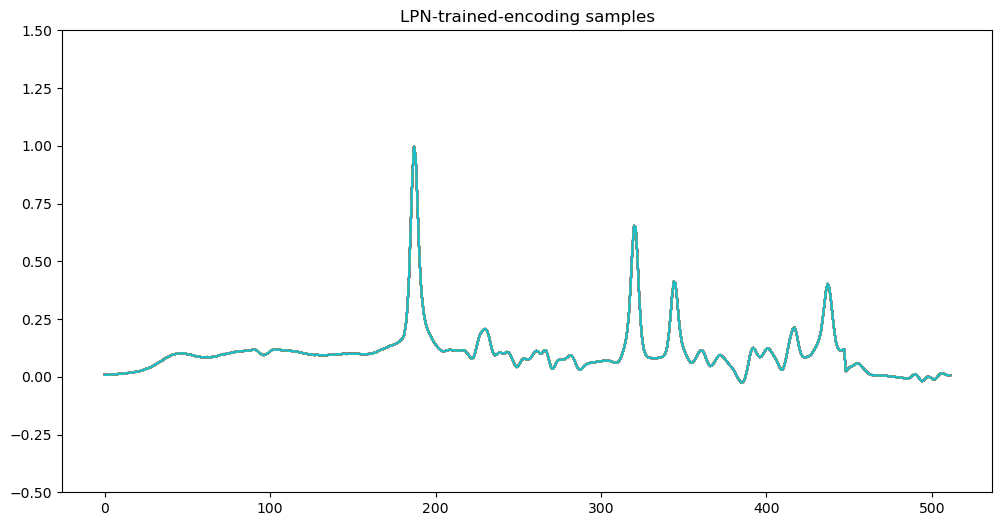

In [ ]:
x_lpn_encode_np = x_lpn_encode.squeeze(1).detach().numpy()
plt.figure(figsize=(12,6))
for i in range(len(x_lpn_encode_np)):
    plt.plot(x_lpn_encode_np[i,:])
plt.title('LPN-trained-encoding samples')
plt.ylim(-0.5, 1.5)
plt.show()

4. Langevin Sampling for LPN fixed encoding

In [38]:
kernel = 3
hidden = 30
sigma_min = 0.001
sigma_max = 0.1
max_iter = 500
model_name = 'LPN_cond'

model = LPN_cond(in_dim = 1, hidden_c=1, hidden=hidden, kernel=kernel, beta=10, alpha=1e-6)
model.load_state_dict(torch.load(f"../weights/{model_name.lower()}_mrs_h_{hidden}_k_{kernel}_n_({sigma_min}_{sigma_max})/LPN_best.pt"))

<All keys matched successfully>

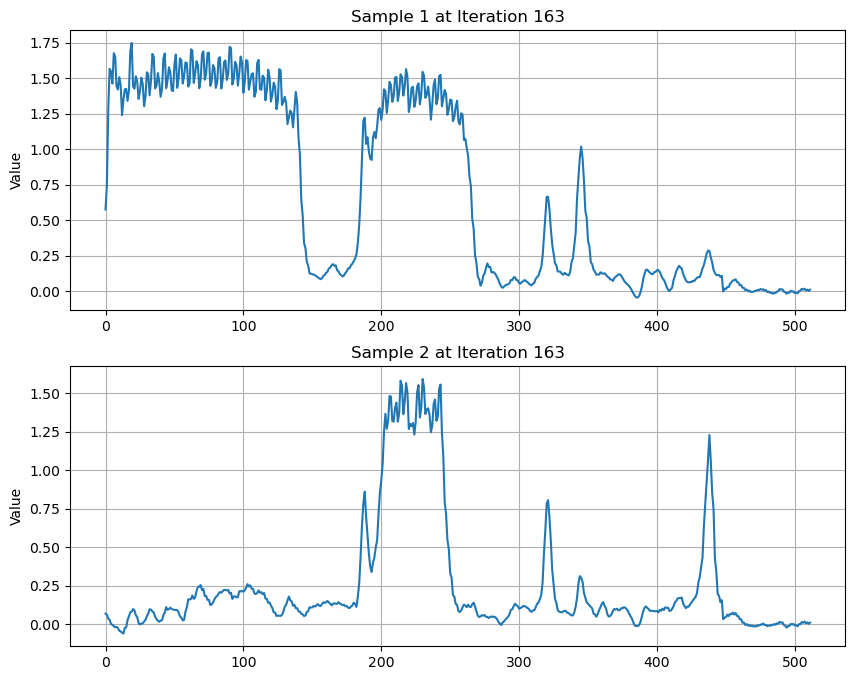

KeyboardInterrupt: 

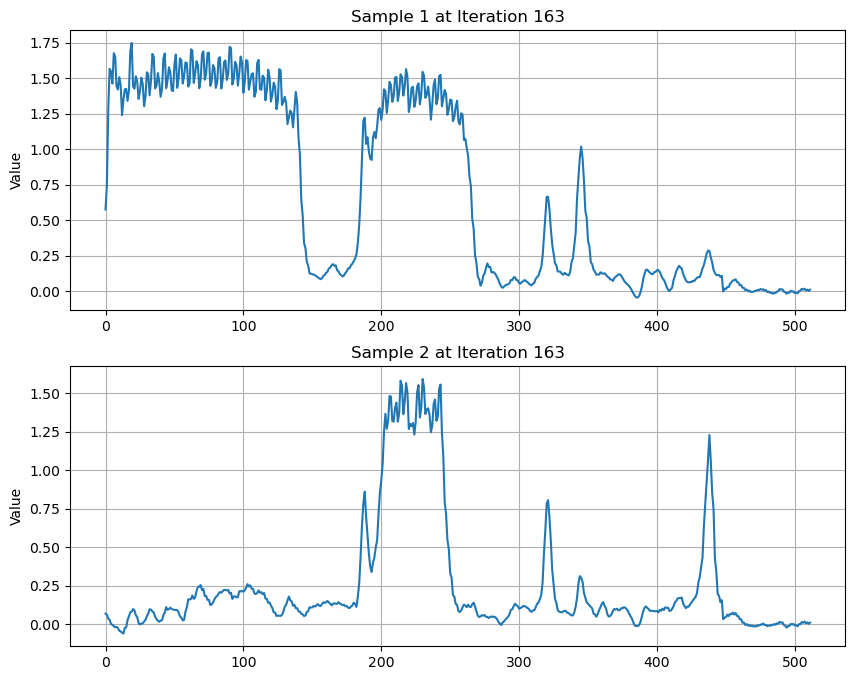

In [39]:
x_lpn = np.tile(x0, (n_samples, 1))
x_lpn = torch.tensor(x_lpn).unsqueeze(1)

projections_lpn = []

plt.ion()  # Enable interactive mode for real-time plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for it in range(max_iter):
    current_sample = x_lpn.squeeze(1).detach().cpu().numpy()
    proj = (current_sample - mean) @ pc_vector.T
    projections_lpn.append(proj)
    
    clear_output(wait=True)

    for i in range(2):
        axs[i].cla()  # Clear axes
        axs[i].plot(current_sample[i]) 
        axs[i].set_title(f'Sample {i + 1} at Iteration {it + 1}') 
        axs[i].set_ylabel('Value')
        axs[i].grid(True)

    display(fig)

    stage_id = it // (max_iter // num_stage)
    sigma = noise_schedule[stage_id]

    noise_levels = torch.full((n_samples,1), sigma)
    x_lpn = model(x_lpn + torch.randn_like(x_lpn) * sigma * np.sqrt(2), noise_levels)

# After the loop, keep the plot open
plt.ioff()  # Disable interactive mode
plt.show()

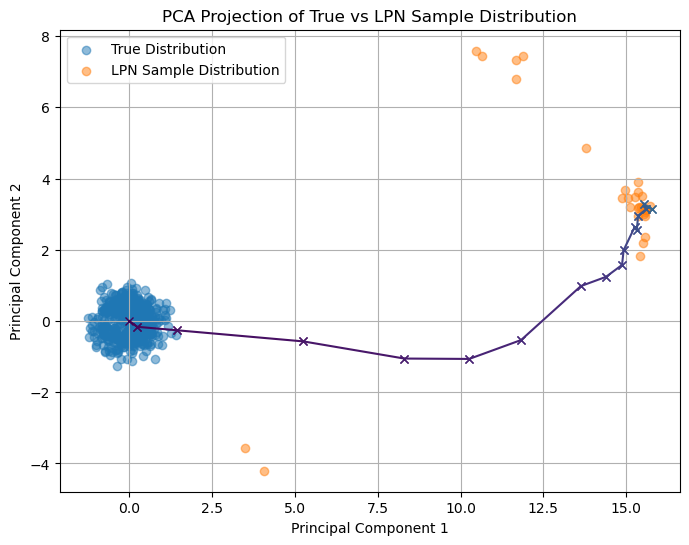

In [40]:
proj_lpn = np.array(projections_lpn)
colors = np.linspace(0, 1, max_iter)
step_size = 10

plt.figure(figsize=(8, 6))
plt.scatter(true_proj[:, 0], true_proj[:, 1], alpha=0.5, label='True Distribution')
plt.scatter(proj_lpn[-1][:, 0], proj_lpn[-1][:, 1], alpha=0.5, label='LPN Sample Distribution')

for i in range(0, max_iter, step_size):
    plt.plot(proj_lpn[i:(i + step_size + 1):step_size,10,0], proj_lpn[i:(i + step_size + 1):step_size, 10, 1], marker='x', color=plt.cm.viridis(colors[int(i)]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of True vs LPN Sample Distribution')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x_lpn_np = x_lpn.squeeze(1).detach().numpy()
plt.figure(figsize=(12,6))
for i in range(len(x_lpn_np)):
    plt.plot(x_lpn_np[i,:])
plt.title('LPN Generated samples')
plt.ylim(-0.5, 1.5)
plt.show()

6. Langevin sampling for LPN with fixed stepsize

In [9]:
kernel = 3
hidden = 30
sigma = 0.01
max_iter = 500
model_name = 'LPN'

model = LPN(in_dim = 1, hidden=hidden, kernel=kernel, beta=10, alpha=1e-6)
model.load_state_dict(torch.load(f"../weights/{model_name.lower()}_mrs_h_{hidden}_k_{kernel}_n_({sigma}_{sigma})/LPN_best.pt"))

<All keys matched successfully>

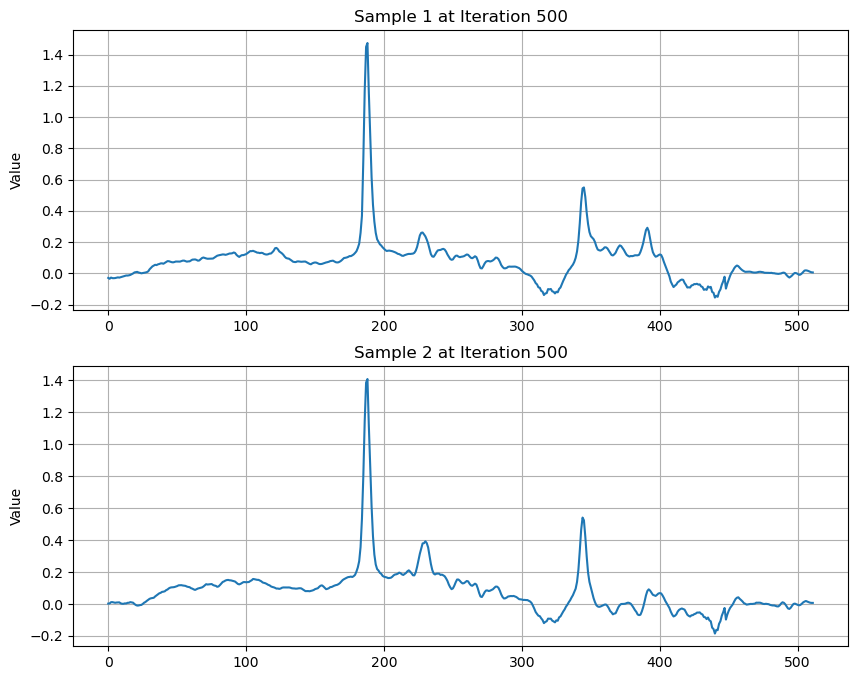

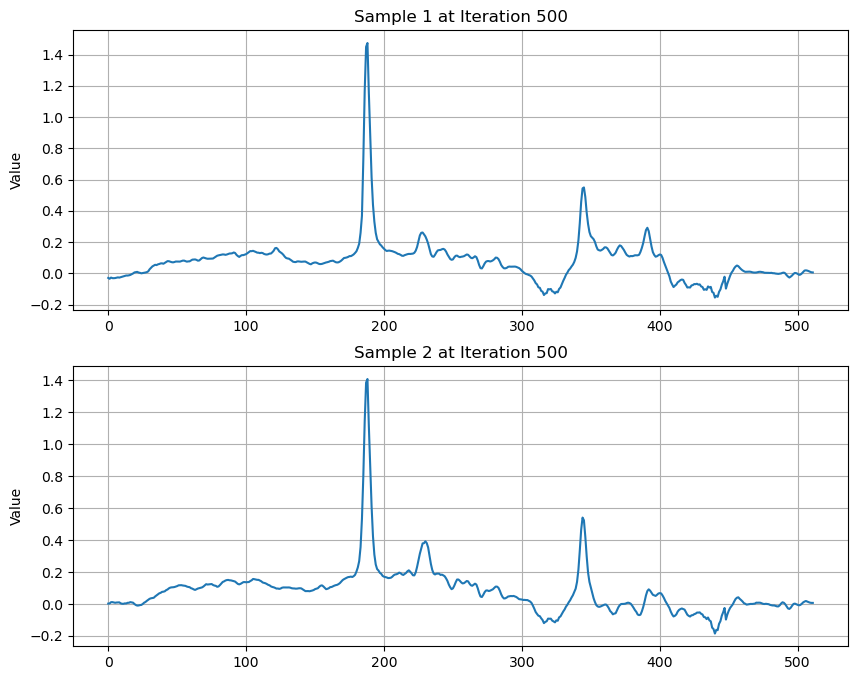

In [10]:
x_lpn_uncond = np.tile(x0, (n_samples, 1))
x_lpn_uncond = torch.tensor(x_lpn_uncond).unsqueeze(1)

projections_lpn_uncond = []

plt.ion()  # Enable interactive mode for real-time plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

for it in range(max_iter):
    current_sample = x_lpn_uncond.squeeze(1).detach().cpu().numpy()
    proj = (current_sample - mean) @ pc_vector.T
    projections_lpn_uncond.append(proj)
    
    clear_output(wait=True)

    for i in range(2):
        axs[i].cla()  # Clear axes
        axs[i].plot(current_sample[i]) 
        axs[i].set_title(f'Sample {i + 1} at Iteration {it + 1}') 
        axs[i].set_ylabel('Value')
        axs[i].grid(True)

    display(fig)

    x_lpn_uncond = model(x_lpn_uncond + torch.randn_like(x_lpn_uncond) * sigma * np.sqrt(2))

# After the loop, keep the plot open
plt.ioff()  # Disable interactive mode
plt.show()

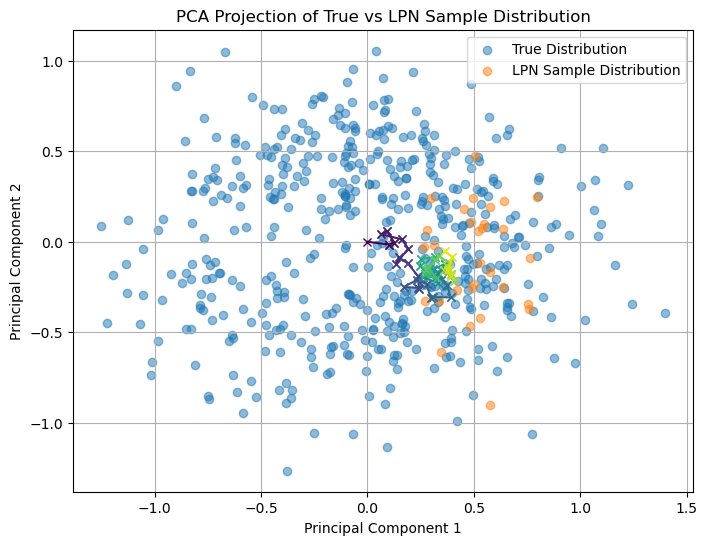

In [11]:
proj_lpn_uncond = np.array(projections_lpn_uncond)
colors = np.linspace(0, 1, max_iter)
step_size = 10

plt.figure(figsize=(8, 6))
plt.scatter(true_proj[:, 0], true_proj[:, 1], alpha=0.5, label='True Distribution')
plt.scatter(proj_lpn_uncond[-1][:, 0], proj_lpn_uncond[-1][:, 1], alpha=0.5, label='LPN Sample Distribution')

for i in range(0, max_iter, step_size):
    plt.plot(proj_lpn_uncond[i:(i + step_size + 1):step_size,10,0], proj_lpn_uncond[i:(i + step_size + 1):step_size, 10, 1], marker='x', color=plt.cm.viridis(colors[int(i)]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of True vs LPN Sample Distribution')
plt.legend()
plt.grid(True)
plt.show()

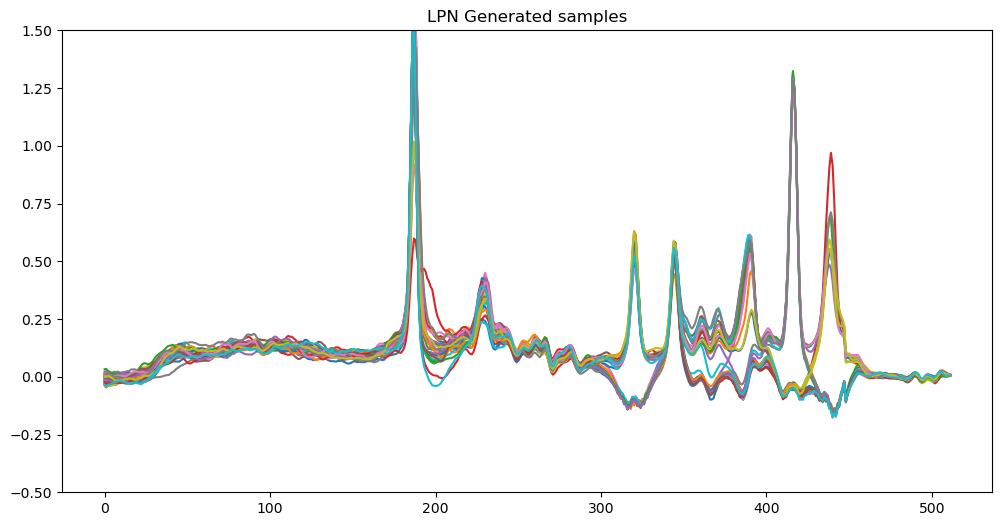

In [12]:
x_lpn_uncond_np = x_lpn_uncond.squeeze(1).detach().numpy()
plt.figure(figsize=(12,6))
for i in range(len(x_lpn_uncond_np)):
    plt.plot(x_lpn_uncond_np[i,:])
plt.title('LPN Generated samples')
plt.ylim(-0.5, 1.5)
plt.show()